### Importando as bibliotecas

In [129]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

In [130]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, accuracy_score

In [131]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format

##### Carregando o arquivo CSV

In [132]:
df = pd.read_csv('heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.00,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.00,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.00,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.50,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.00,Up,0


In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [134]:
# Verificando se há valores nulos 
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [135]:
# Variavel para poder vizualizar os valores unicos de cada variavel
valors_unicos = [] #criado uma lista vazia
for i in df.columns[0:12].tolist():
    print(i, ':', len(df[i].astype(str).value_counts()))
    valors_unicos.append(len(df[i].astype(str).value_counts()))

Age : 50
Sex : 2
ChestPainType : 4
RestingBP : 67
Cholesterol : 222
FastingBS : 2
RestingECG : 3
MaxHR : 119
ExerciseAngina : 2
Oldpeak : 53
ST_Slope : 3
HeartDisease : 2


In [136]:
# vizualizando algumas médidas estatisticas
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.00,918.00,918.00,918.00,918.00,918.00,918.00
mean,53.51,132.40,198.80,0.23,136.81,0.89,0.55
std,9.43,18.51,109.38,0.42,25.46,1.07,0.50
min,28.00,0.00,0.00,0.00,60.00,-2.60,0.00
25%,47.00,120.00,173.25,0.00,120.00,0.00,0.00
50%,54.00,130.00,223.00,0.00,138.00,0.60,1.00
75%,60.00,140.00,267.00,0.00,156.00,1.50,1.00
max,77.00,200.00,603.00,1.00,202.00,6.20,1.00


#### Analisando variaveis catégoricas em relação a variavel alvo

In [137]:
# Formatando o tamanho do plot
plt.rcParams['figure.figsize'] = [8.00,4.00]
plt.rcParams['figure.autolayout'] = True

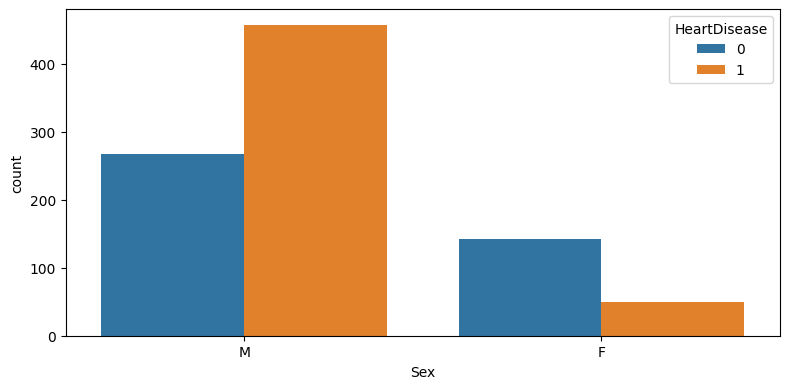

In [138]:
# Visualizando a variavel Sex x HeartDisease
sns.countplot(data = df, x = 'Sex', hue = 'HeartDisease')
plt.show()

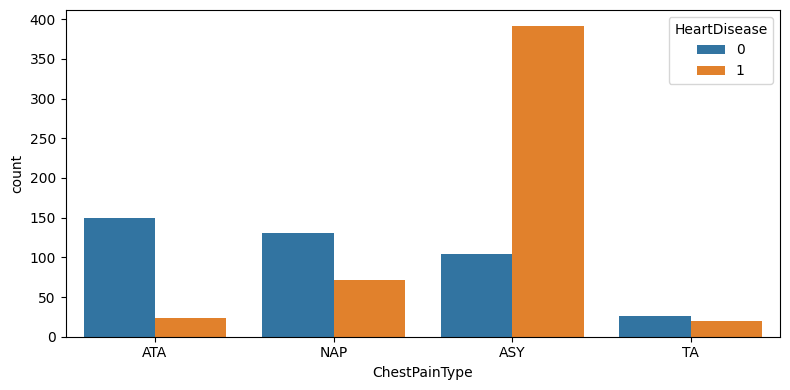

In [139]:
# Visualizando a variavel ChestPainType x HeartDisease
sns.countplot(data = df, x = 'ChestPainType', hue = 'HeartDisease')
plt.show()

In [140]:
# Convertendo as variaveis do tipo object para Category (para melhor alocação de espaço na memoria)
df['Sex'] = df['Sex'].astype('category')
df['ChestPainType'] = df['ChestPainType'].astype('category')
df['RestingECG'] = df['RestingECG'].astype('category')
df['ExerciseAngina'] = df['ExerciseAngina'].astype('category')
df['ST_Slope'] = df['ST_Slope'].astype('category')
df['FastingBS'] = df['FastingBS'].astype('category')


In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Age             918 non-null    int64   
 1   Sex             918 non-null    category
 2   ChestPainType   918 non-null    category
 3   RestingBP       918 non-null    int64   
 4   Cholesterol     918 non-null    int64   
 5   FastingBS       918 non-null    category
 6   RestingECG      918 non-null    category
 7   MaxHR           918 non-null    int64   
 8   ExerciseAngina  918 non-null    category
 9   Oldpeak         918 non-null    float64 
 10  ST_Slope        918 non-null    category
 11  HeartDisease    918 non-null    int64   
dtypes: category(6), float64(1), int64(5)
memory usage: 49.4 KB


In [142]:
# recarregar variaveis para plot
variaveis_numericas = []
for i in df.columns[0:11].tolist(): #aqui estou excluindo a vairavel alvo HeartDisease
    if df.dtypes[i] == 'int64' or df.dtypes[i] == 'float64':
        variaveis_numericas.append(i)

variaveis_numericas

['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

In [143]:
len(variaveis_numericas)

5

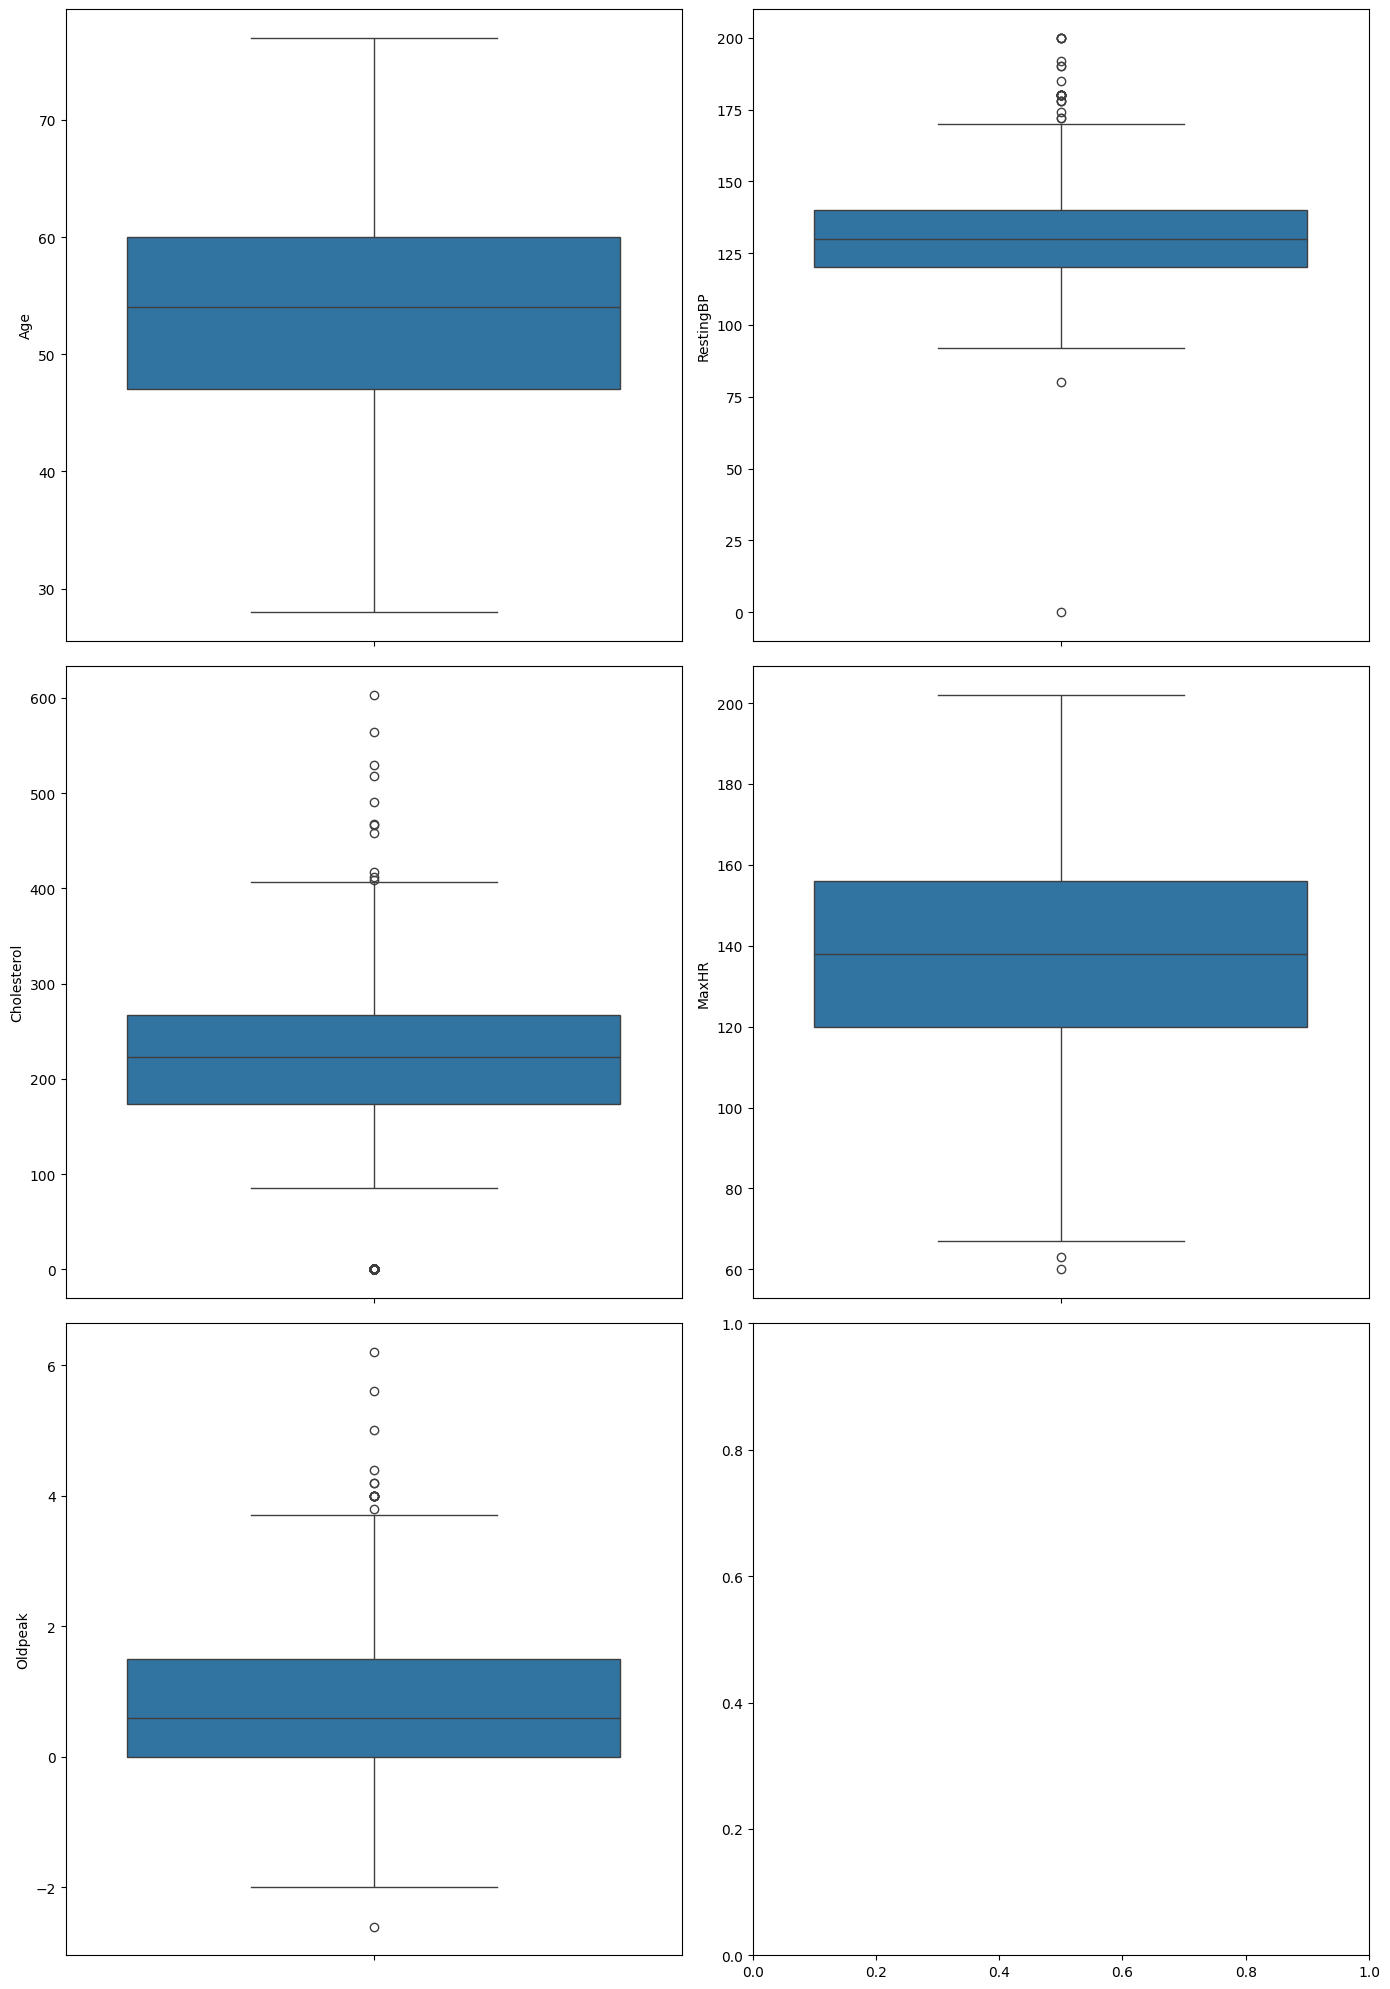

In [144]:
# Podemos observar nos boxplots abaixo que as variaveis numéricas apresentam uma grande quantidade de "possíveis" outliers
# Precisamos avaliar cada uma dessas variaveis dentro do contexto dos dados para saber se realmente iremos trata-los como outliar

plt.rcParams['figure.figsize'] = [14.00,20.00]
plt.rcParams['figure.autolayout'] = True
f,axes = plt.subplots(3, 2) # 3 linhas e 2 colunas

linha = 0
coluna = 0
for i in variaveis_numericas:
    sns.boxplot(data = df, y=i, ax=axes[linha][coluna])
    coluna += 1
    if coluna == 2:
        linha += 1
        coluna = 0

plt.show()

Os boxplots, permitem observar a distribuição dos dados de variáveis relacionadas à saúde, como idade, pressão arterial, colesterol, frequência cardíaca e outras características. <br>
Cada boxplot fornece informações sobre o intervalo interquartil (IQR), valores mínimos e máximos, e a presença de outliers (pontos fora do intervalo típico dos dados).

Age: A idade dos participantes esta concentrada entre 50 e 60 anos, com uma faixa bem distribuída. Não há presença significativa de outliers.

RestingBP: A maioria dos valores de pressão arterial em repouso está concentrada entre 120 e 140, mas há outliers significativos que indicam valores mais elevados. Também há alguns valores muito baixos que podem representar erros de medição ou casos atípicos.

Cholesterol: A distribuição do colesterol é mais ampla, com um IQR entre aproximadamente 200 e 300. Há muitos outliers acima de 400, indicando casos de níveis de colesterol elevados.

MaxHR: A maioria dos valores de frequência cardíaca máxima está entre 120 e 160, sem muitos outliers, o que indica uma distribuição mais uniforme e menos casos atípicos.

Oldpeak: O valor de Oldpeak possui alguns outliers, com a maioria dos valores entre 0 e 2. Alguns valores extremos negativos e positivos indicam variação na população avaliada.

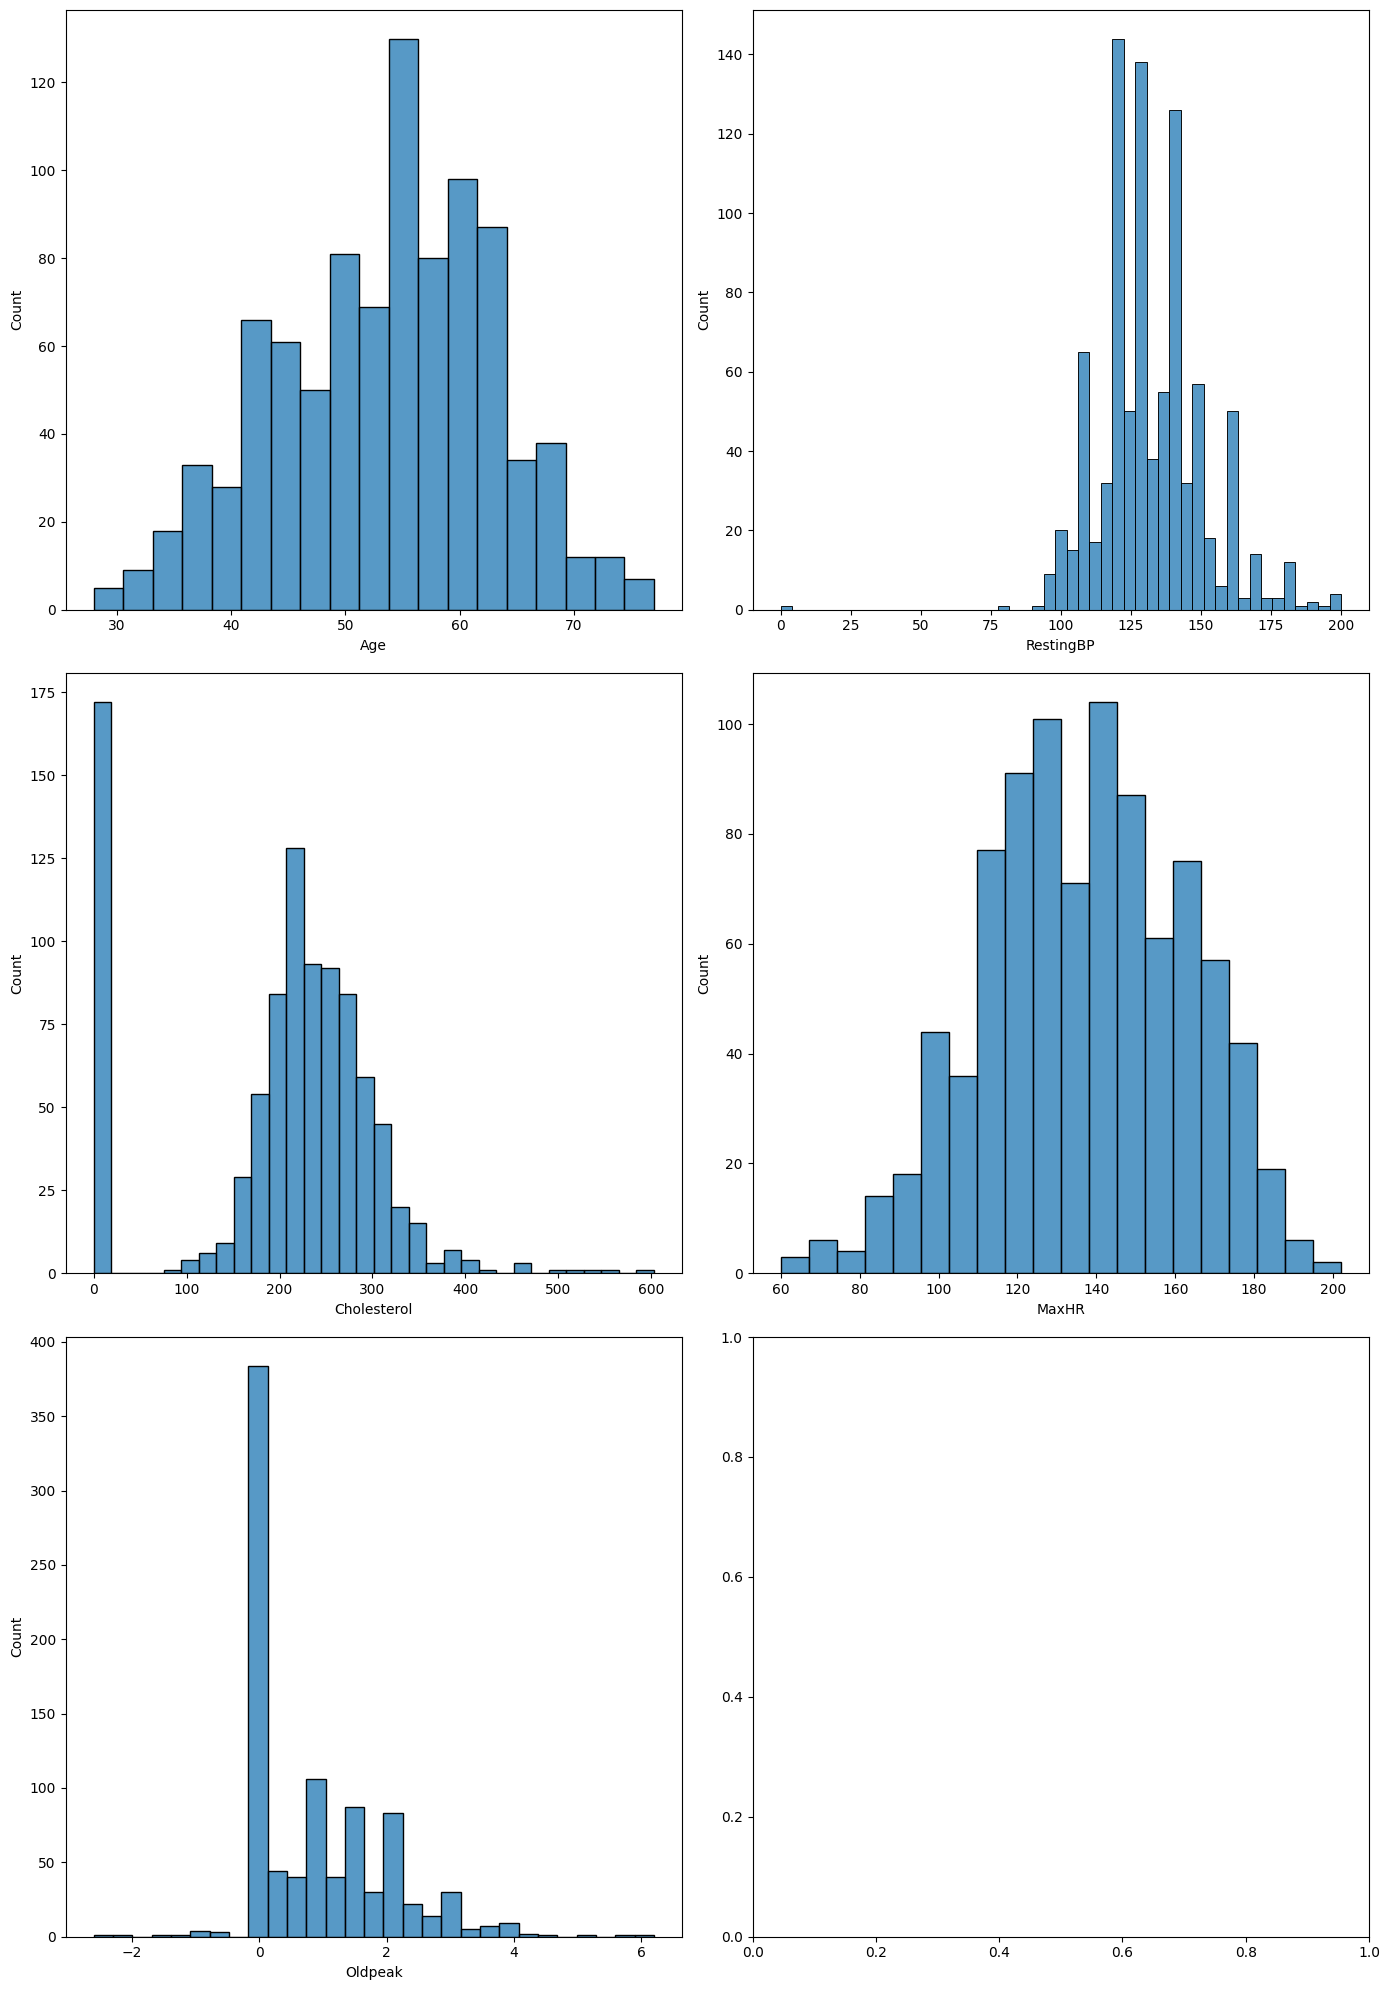

In [145]:
# Podemos observar nos boxplots baixo que as variaveis numericas apresentam uma grande quantidade de "possiveis" outliers
# Precisamos avaliar cada uma dessas variaveis dentro do contexto dos dados para saber se realmente iremos trata-las como outlier

plt.rcParams['figure.figsize'] = [14.00,20.00]
plt.rcParams['figure.autolayout'] = True
f,axes = plt.subplots(3, 2) # 3 linhas e 2 colunas

linha = 0
coluna = 0
for i in variaveis_numericas:
    sns.histplot(data = df, x=i, ax=axes[linha][coluna])
    coluna += 1
    if coluna == 2:
        linha += 1
        coluna = 0

plt.show()

In [146]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.00,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.00,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.00,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.50,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.00,Up,0


In [147]:
# Carregar variaveis categoricas para o OneHotEncoder
# Vamos colocar o slice somente ate a coluna de indice 18 para nao pegar a variavel target
variaveis_categoricas = []
for i in df.columns[0:11].tolist():
    if df.dtypes[i] == 'object' or df.dtypes[i] =='category':
        variaveis_categoricas.append(i)

variaveis_categoricas

['Sex',
 'ChestPainType',
 'FastingBS',
 'RestingECG',
 'ExerciseAngina',
 'ST_Slope']

In [148]:
# Criar o enconder e aplica OneHotEncoder
lb = LabelEncoder()
for i in variaveis_categoricas:
    df[i] = lb.fit_transform(df[i])

In [149]:
# Verifica novamente para conferir se nao surgiu valor nulo
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    int64  
 2   ChestPainType   918 non-null    int64  
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    int64  
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    int64  
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    int64  
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 86.2 KB


In [151]:
# agora os campos que antes tinham strings estao com numeros
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.00,2,0
1,49,0,2,160,180,0,1,156,0,1.00,1,1
2,37,1,1,130,283,0,2,98,0,0.00,2,0
3,48,0,0,138,214,0,1,108,1,1.50,1,1
4,54,1,2,150,195,0,1,122,0,0.00,2,0


In [152]:
# Visualizando a quantidade da varival target para o balanceamento
variavel_target = df.HeartDisease.value_counts()
variavel_target

HeartDisease
1    508
0    410
Name: count, dtype: int64

In [153]:
# Separat as variaveis preditores e target
PREDITORAS = df.iloc[:,0:11]
TARGET = df.iloc[:,11]

In [154]:
PREDITORAS.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40,1,1,140,289,0,1,172,0,0.00,2
1,49,0,2,160,180,0,1,156,0,1.00,1
2,37,1,1,130,283,0,2,98,0,0.00,2
3,48,0,0,138,214,0,1,108,1,1.50,1
4,54,1,2,150,195,0,1,122,0,0.00,2


In [155]:
TARGET.head()

0    0
1    1
2    0
3    1
4    0
Name: HeartDisease, dtype: int64

Usando o balanceamento SMOTE, uma técnica que visa equilibrar o número de amostras entre as classes de um conjunto de dados

In [156]:
# Seed para reproduzir o mesmo resultado
seed = 100

# Cria o balanceador SMOTE
balanceador = SMOTE(random_state=seed)

# applica o balanceador
PREDITORAS_RES, TARGET_RES = balanceador.fit_resample(PREDITORAS,TARGET)

<Axes: title={'center': 'Doença Cardiaca'}, xlabel='HeartDisease'>

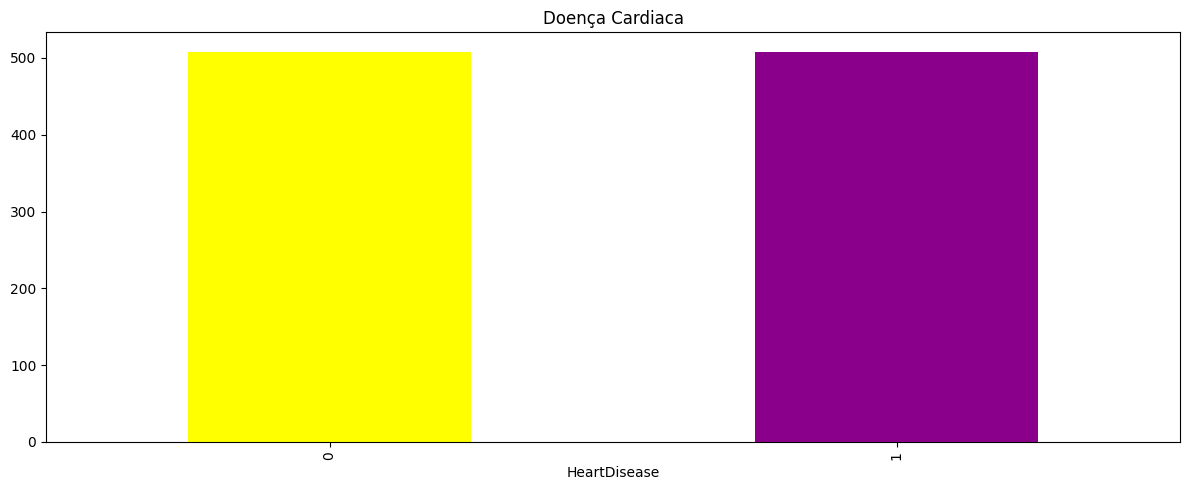

In [157]:
plt.rcParams['figure.figsize'] = [12.00,5.00]
plt.rcParams['figure.autolayout'] = True
TARGET_RES.value_counts().plot(kind='bar', title='Doença Cardiaca', color= ('#FFFF00','#8B008B'))

In [158]:
# Quantidades de registros antes do balanciamento
PREDITORAS.shape

(918, 11)

In [159]:
# Quantidades de registros depois do balanciamento
PREDITORAS_RES.shape


(1016, 11)

In [160]:
# Quantidades de registros antes do balanciamento
TARGET.shape

(918,)

In [161]:
# Quantidades de registros depois do balanciamento
TARGET_RES.shape

(1016,)

##### Agora vamos dividir os dados em dados de treino e teste para iniciarmos a etapa de criação do modelo

In [162]:
# Divisão em Dados de Treino e Teste
X_treino, X_teste, Y_treino, Y_teste = train_test_split(PREDITORAS_RES, TARGET_RES, test_size=0.3, random_state= 42)

In [163]:
X_treino.shape

(711, 11)

In [164]:
X_treino.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
177,59,1,1,140,287,0,1,150,0,0.00,2
467,63,0,1,132,0,0,1,130,0,0.10,2
507,40,1,2,106,240,0,1,80,1,0.00,2
486,55,1,1,110,214,1,2,180,0,0.40,2
328,52,1,0,95,0,1,1,82,1,0.80,1


In [165]:
# Normalização das variaveis
Normalizador = MinMaxScaler()
X_treino_normalizados = Normalizador.fit_transform(X_treino)
X_teste_normalizados = Normalizador.transform(X_teste)


In [166]:
# Visualizando os dados normalizados
X_treino_normalizados.shape

(711, 11)

In [167]:
X_treino_normalizados

array([[0.625     , 1.        , 0.33333333, ..., 0.        , 0.31707317,
        1.        ],
       [0.70833333, 0.        , 0.33333333, ..., 0.        , 0.32926829,
        1.        ],
       [0.22916667, 1.        , 0.66666667, ..., 1.        , 0.31707317,
        1.        ],
       ...,
       [0.64583333, 1.        , 0.        , ..., 1.        , 0.48780488,
        1.        ],
       [0.64583333, 1.        , 0.        , ..., 1.        , 0.31707317,
        1.        ],
       [0.22916667, 0.        , 0.        , ..., 0.        , 0.56097561,
        0.5       ]])

#### Criando, Treinando e Avaliando os Modelos de Machine Learning

In [168]:
# Criando o classificador com Random Forest
clf = RandomForestClassifier(n_estimators= 300, criterion= 'entropy', max_depth= 10, max_features= 'sqrt', min_samples_leaf= 2, min_samples_split= 2, n_jobs= 8)

# Construção do modelo
clf = clf.fit(X_treino_normalizados, Y_treino)

<function matplotlib.pyplot.show(close=None, block=None)>

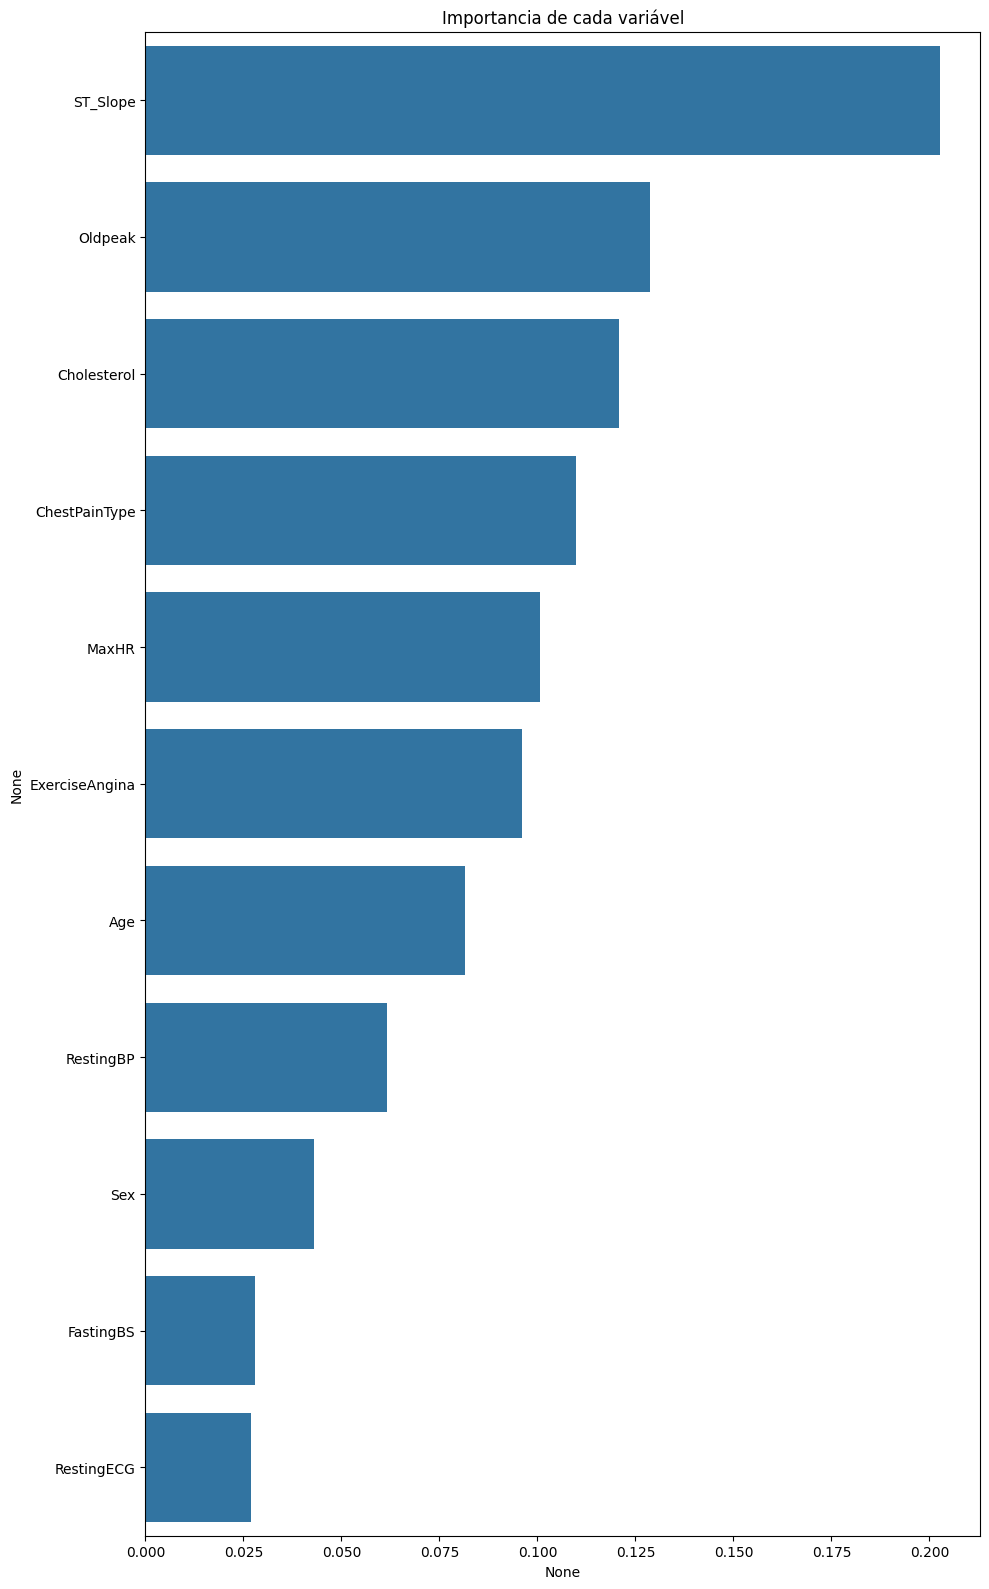

In [169]:
# Exibindo a importancia de cada variavel no modelo preditivo
plt.rcParams['figure.figsize'] = [10.00,16.00]
plt.rcParams['figure.autolayout'] = True

importances = pd.Series(data=clf.feature_importances_, index= PREDITORAS.columns)
importances = importances.sort_values(ascending = False)
sns.barplot (x=importances, y=importances.index, orient='h').set_title('Importancia de cada variável')
plt.show

In [170]:
# Viualizando o percentual de importancia de cada variavel
importances.sort_values(ascending= False)

ST_Slope         0.20
Oldpeak          0.13
Cholesterol      0.12
ChestPainType    0.11
MaxHR            0.10
ExerciseAngina   0.10
Age              0.08
RestingBP        0.06
Sex              0.04
FastingBS        0.03
RestingECG       0.03
dtype: float64

In [171]:
#Apenas "simmluando" os dados de teste
scores = clf.score(X_treino_normalizados, Y_treino)
scores

0.9648382559774965

In [172]:
# Apenas "simmluando" os dados de teste
scores = clf.score(X_teste_normalizados, Y_teste)
scores

0.8819672131147541

In [173]:
# previsoes dos dados normalizados
y_pred = clf.predict(X_teste_normalizados)
print(accuracy_score(Y_teste, y_pred)*100)

88.19672131147541


In [174]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print(confusion_matrix(Y_teste, y_pred))

[[120  18]
 [ 18 149]]


In [175]:
from sklearn.metrics import classification_report
print(classification_report(Y_teste, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       138
           1       0.89      0.89      0.89       167

    accuracy                           0.88       305
   macro avg       0.88      0.88      0.88       305
weighted avg       0.88      0.88      0.88       305



In [176]:
cm = confusion_matrix(Y_teste, y_pred)
print(cm)

[[120  18]
 [ 18 149]]


In [177]:
cm_disp = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels = ['Sim','Não'])

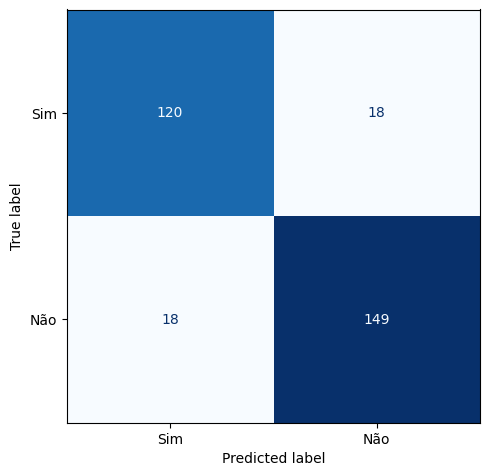

In [178]:
plt.rcParams['figure.figsize'] = [5.00,5.00]
plt.rcParams['figure.autolayout'] = True
cm_disp.plot(include_values=True, cmap ='Blues', colorbar= None)

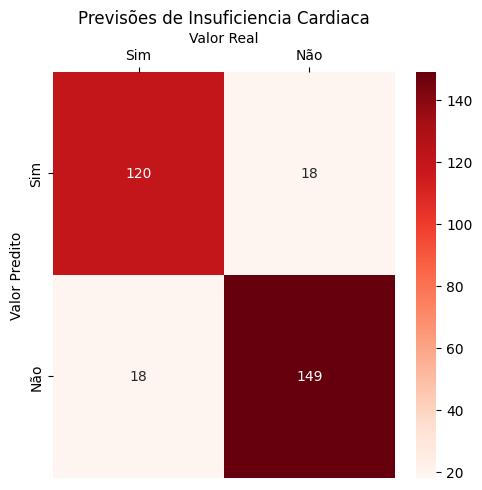

In [179]:
pd.options.display.float_format = '{:.2f}'.format

plt.rcParams['figure.figsize'] = [5.00,5.00]
plt.rcParams['figure.autolayout'] = True

f, ax = plt.subplots(figsize=(5,5))

sns.heatmap(cm,
            cmap= 'Reds',
            annot= True,
            cbar_kws= {'orientation':'vertical'},
            fmt= ".0f",
            xticklabels=["Sim","Não"],
            yticklabels=["Sim","Não"])

ax.set_ylabel('Valor Predito')
ax.set_xlabel('Valor Real')

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

plt.title("Previsões de Insuficiencia Cardiaca")
plt.tick_params(axis="both", which='major', labelsize=10, labelbottom =False, top=True, labeltop=True)
plt.show()

O modelo está prevendo se um paciente possui insuficiência cardíaca ("Sim") ou não ("Não").

O eixo vertical ("Valor Predito") representa as previsões feitas pelo modelo.</br>
O eixo horizontal ("Valor Real") representa os valores reais dos dados.

O heatmap usa uma escala de cor vermelha para destacar a quantidade de previsões em cada célula. Quanto mais escura a cor, maior a quantidade de acertos ou erros, facilitando a identificar visualmente onde o modelo está acertando ou errando mais.

118 (Sim, Sim): Representa as previsões corretas onde o modelo previu "Sim" para insuficiência cardíaca e o valor real também era "Sim" (True Positive).</br>
20 (Sim, Não): Indica os casos em que o modelo previu "Não", mas o valor real era "Sim" (False Negative), ou seja, falsos negativos.</br>
18 (Não, Sim): Indica previsões em que o modelo disse "Sim" para insuficiência cardíaca, mas o valor real era "Não" (False Positive), ou seja, falsos positivos.</br>
149 (Não, Não): Representa as previsões corretas em que o modelo previu "Não" e o valor real também era "Não" (True Negative).</br>